In [1]:
#Define paths for current project

from pathlib import Path
from datetime import datetime

#Run ID to be used for naming output files
RUN_ID = datetime.now().strftime("%Y%m%d")
RUNID_DASH = datetime.now().strftime("%Y-%m-%d")

RUN_ID = "20250827"
RUNID_DASH = "2025-08-27"



# --- Centralized paths ---
ROOT = Path("..")
DATA = ROOT / "data"
LOGS = ROOT / "logs"
SCRIPTS = ROOT / "scripts"
RESULTS = ROOT / "results"
ALIGN_DIR = RESULTS / "align"
TREE_DIR = RESULTS / "trees"
FIGURES = RESULTS / "figures"

# --- Key files ---
GR_FASTA = DATA / "GR.fasta" #Starting file for BLAST search 
BLAST_OUT = DATA / "BAC88139.1_top150_uniref90.fasta"
RENAMED_FASTA = DATA / "BAC88139.1_top150_uniref90.rename.fasta"

CULLED_FASTA = DATA / f"BAC88139.1_top150_uniref90.rename.culled_{RUN_ID}.fasta"
DISCARDED_FASTA = DATA / f"BAC88139.1_top150_uniref90.rename.discarded_{RUN_ID}.fasta"
SUMMARY_CSV = LOGS / f"GR_max_similarity_{RUN_ID}.csv"

# --- Alignment and tree output ---
ALIGN_DIR.mkdir(parents=True, exist_ok=True)
TREE_DIR.mkdir(parents=True, exist_ok=True)
ALN_FASTA = ALIGN_DIR / f"BAC88139.1_top150_uniref90.rename.culled_{RUN_ID}_ALN.faa"
IQ_PREFIX = TREE_DIR / f"BAC88139.1_top150_uniref90.rename.culled_{RUN_ID}_ML_{RUNID_DASH}"

lmax_table_max = FIGURES / "lmax_table_max.txt"
lmax_table_min = FIGURES / "lmax_table_min.txt"


In [2]:
#Find the highest and lowest lmax predictions from the OPTICS output
import pandas as pd
from pathlib import Path

lmax_tsv = Path("../results/optics/optics_on_optics_predictions_2025-08-28_22-04-07/optics_predictions_predictions.tsv")
lmax_table_max = FIGURES / "lmax_table_max.txt"
lmax_table_min = FIGURES / "lmax_table_min.txt"
N = 10  # Number of highest/lowest lmax genes to extract

print(lmax_tsv)
print(lmax_tsv.exists())

# Read the TSV
lmax_df = pd.read_csv(lmax_tsv, sep="\t")

# Sort by Single_Prediction descending and get top N (max)
lmax_top = lmax_df.sort_values("Single_Prediction", ascending=False).head(N)

# Sort by Single_Prediction ascending and get bottom N (min)
lmax_bottom = lmax_df.sort_values("Single_Prediction", ascending=True).head(N)

# Write gene names to max file
with open(lmax_table_max, "w") as f:
    for name in lmax_top["Names"]:
        f.write(str(name) + "\n")

# Write gene names to min file
with open(lmax_table_min, "w") as f:
    for name in lmax_bottom["Names"]:
        f.write(str(name) + "\n")

print(f"Wrote top {N} gene names to {lmax_table_max}")
print(f"Wrote bottom {N} gene names to {lmax_table_min}")

../results/optics/optics_on_optics_predictions_2025-08-28_22-04-07/optics_predictions_predictions.tsv
True
Wrote top 10 gene names to ../results/figures/lmax_table_max.txt
Wrote bottom 10 gene names to ../results/figures/lmax_table_min.txt


In [5]:
# Run greedy_max_diversity on max and min lmax gene lists and save selected taxa

import sys
sys.path.append(str(SCRIPTS))  # SCRIPTS is  defined in the first cell of the notebook
from max_phylo_diversity import greedy_max_diversity
from Bio import Phylo
from pathlib import Path

# Tree file
tree_file = TREE_DIR / f"combined_deduped_{RUN_ID}_ML_{RUNID_DASH}.treefile"

# Input files
max_file = Path("../results/figures/lmax_table_max.txt")
min_file = Path("../results/figures/lmax_table_min.txt")

# Output files
out_max = Path("../results/figures/diverse_lmax_table_max.txt")
out_min = Path("../results/figures/diverse_lmax_table_min.txt")

y = 5  # Number of diverse taxa to select

tree = Phylo.read(tree_file, "newick")

# Helper to read gene list
def read_genes(path):
    with open(path) as f:
        return [line.strip() for line in f if line.strip()]

max_genes = read_genes(max_file)
min_genes = read_genes(min_file)

selected_max = greedy_max_diversity(tree, max_genes, y)
selected_min = greedy_max_diversity(tree, min_genes, y)

with open(out_max, "w") as f:
    for name in selected_max:
        f.write(str(name) + "\n")
with open(out_min, "w") as f:
    for name in selected_min:
        f.write(str(name) + "\n")

print(f"Wrote {y} diverse taxa from max lmax to {out_max}")
print(f"Wrote {y} diverse taxa from min lmax to {out_min}")

Wrote 5 diverse taxa from max lmax to ../results/figures/diverse_lmax_table_max.txt
Wrote 5 diverse taxa from min lmax to ../results/figures/diverse_lmax_table_min.txt


In [6]:
# Combine lmax_table_max.txt and lmax_table_min.txt into a 2-column TSV for plot_tree.py coloring
from pathlib import Path

max_file = Path("../results/figures/diverse_lmax_table_max.txt")
min_file = Path("../results/figures/diverse_lmax_table_min.txt")
color_tsv = Path("../results/figures/lmax_table_color.tsv")

with open(max_file) as f:
    max_genes = [line.strip() for line in f if line.strip()]
with open(min_file) as f:
    min_genes = [line.strip() for line in f if line.strip()]

with open(color_tsv, "w") as f:
    for gene in max_genes:
        f.write(f"{gene}\tred\n")
    for gene in min_genes:
        f.write(f"{gene}\tblue\n")

print(f"Wrote color table for plot_tree.py to {color_tsv}")

Wrote color table for plot_tree.py to ../results/figures/lmax_table_color.tsv


Saved tree figure to: ../results/figures/combined_deduped_20250827_tree.pdf


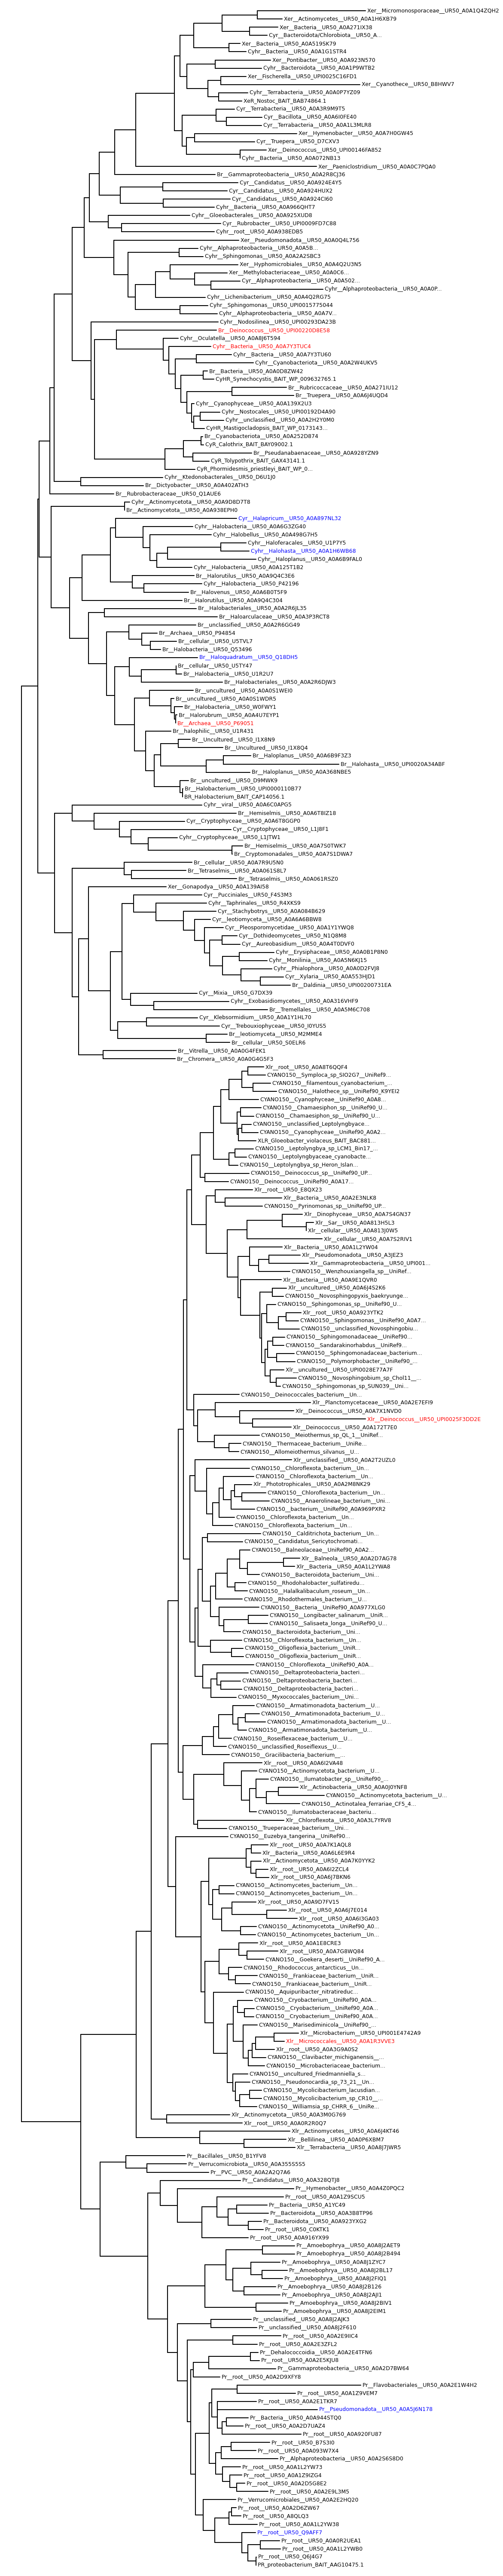

In [7]:
#Now print the phylogeny coloring max and min lmax red and blue, respectively
import sys
sys.path.append(str(SCRIPTS))
from plot_tree import plot_tree

# Path to  specific treefile
tree_file = TREE_DIR / f"combined_deduped_{RUN_ID}_ML_{RUNID_DASH}.treefile"
fig_path = FIGURES / f"combined_deduped_{RUN_ID}_tree.pdf"
color_tsv = Path("../results/figures/lmax_table_color.tsv")

plot_tree(
    tree_file,
    color_tsv=color_tsv,
    save_path=fig_path,
    figsize=(12, 60)
 )